# 3. Empirical validation and insights

This notebook contains the code to validate the theory using the empirical data and to gain additional insights into the empirical data based on the theory in the paper: "Variability of functional and biodiversity responses to perturbations is predictable and informative" by James A. Orr, Jeremy J. Piggott, Andrew L. Jackson, Michelle C. Jackson and Jean-François Arnoldi.

Code runs for Python 3.11.5 (November 2023). 

### Contents  <a class="anchor" id="1"></a>
* [Data organisation](#2)
* [Empirical Validation](#3)
* [Empirical Insights](#4)

### Packages and Functions 

In [1]:
import pandas as pd                  # general data organisation         
import numpy as np                   # general work with matrices and vectors 
import matplotlib.pyplot as plt      # general plotting work
from scipy import stats              # general statistics 
from numpy.linalg import norm, inv   # matrix tools
import networkx as nx                # for plotting a network
import matplotlib.colors as mcolors  # for colors 

# for text formating 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",  
})

# set colours 
grass_col = '#b89247'
forest_col = '#377A49'


# print Python version
from platform import python_version
python_version()


'3.11.5'

<br>
<br>

## Data organisation  <a class="anchor" id="2"></a>
[Top](#1)

First we'll load the full dataset

In [2]:
zhou_data = pd.read_csv("data/Zhou et al 2020 Data.csv", index_col="Observation")

Define a function that takes two functions from the dataset and returns their proportion of mismatches

In [3]:
def mismatches(data, X, Y, min_obs):
    
    # select functions X and Y and only keep complete rows
    sub = data[[X, Y]].dropna()
    
    # if they are the same function return 0 proportion of mismatches
    if X == Y:
        return 0
    
    # if there are less than min_obs observations return nan
    if len(sub) < min_obs:
        return np.nan
    
    # otherwise return the proportion of mismatches (sum of rows where signs aren't the same divided by all rows)
    else:
        return np.sum(np.sign(sub[X]) != np.sign(sub[Y])) / len(sub)

Create a list of functions to run this mismatch function with

In [4]:
# list of functions from the zhou dataset 
functions = ["PO", "PER", "AG", "BG", "CEL", "XYL", "Invertase", "NAG", "LAP", "Urease", "AP",
              "Respiration", "Nmin", "Nitrification", "Denitrification", "Nfixation", "MicrobialBiomass"]

Create a matrix of mismatches for this list of functions (using a minimum observations of 10)

In [5]:
# Initialize an empty DataFrame to store the mismatch_matrix
mismatch_matrix = pd.DataFrame(index=functions, columns=functions)

for X in functions:
    for Y in functions:
        mismatch_matrix.loc[X, Y] = mismatches(zhou_data, X, Y, 10)
        
mismatch_matrix

,PO,PER,AG,BG,CEL,XYL,Invertase,NAG,LAP,Urease,AP,Respiration,Nmin,Nitrification,Denitrification,Nfixation,MicrobialBiomass
PO,0,0.520833,0.5,0.361111,0.488889,0.666667,NaN,0.415094,NaN,0.315789,0.342466,0.511628,NaN,NaN,NaN,NaN,0.245902
PER,0.520833,0,0.4375,0.302326,0.40625,0.625,NaN,0.387097,NaN,NaN,0.567568,0.5,NaN,NaN,NaN,NaN,0.411765
AG,0.5,0.4375,0,0.25,0.25,0.25,NaN,0.378378,0.411765,NaN,0.459459,0.388889,NaN,NaN,NaN,NaN,0.611111
BG,0.361111,0.302326,0.25,0,0.1875,0.34,NaN,0.338346,0.302326,NaN,0.31746,0.428571,0.571429,NaN,NaN,NaN,0.416667
CEL,0.488889,0.40625,0.25,0.1875,0,0.073171,NaN,0.328571,0.454545,NaN,0.411765,0.566667,NaN,NaN,NaN,NaN,0.377778
XYL,0.666667,0.625,0.25,0.34,0.073171,0,NaN,0.32,0.45,NaN,0.296296,0.588235,NaN,NaN,NaN,NaN,0.535714
Invertase,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.170213,0.413043,NaN,NaN,NaN,NaN,NaN,0.446809
NAG,0.415094,0.387097,0.378378,0.338346,0.328571,0.32,NaN,0,0.454545,NaN,0.20339,0.615385,0.34375,NaN,NaN,NaN,0.476744
LAP,NaN,NaN,0.411765,0.302326,0.454545,0.45,NaN,0.454545,0,NaN,0.310345,0.222222,0.941176,NaN,NaN,NaN,0.382353
Urease,0.315789,NaN,NaN,NaN,NaN,NaN,0.170213,NaN,NaN,0,0.238806,0.0,0.0,NaN,NaN,NaN,0.433333


We can't have any NaN here for the empirical validation - start remove the functions that are causing the NaN. Invertase, Urease, Nmin, Nitrification, Denitrification, Nfixation all have mostly NaN. LAP has NaN with two other functions. After removing these, we'll be left with a 10 by 10 matrix with no NaN. 

In [6]:
# list of functions from the zhou dataset 
functions = ["PO", "PER", "AG", "BG", "CEL", "XYL", "NAG", "AP",
              "Respiration", "MicrobialBiomass"]

mismatch_matrix = pd.DataFrame(index=functions, columns=functions)

for X in functions:
    for Y in functions:
        mismatch_matrix.loc[X, Y] = mismatches(zhou_data, X, Y, 10)
        
mismatch_matrix

,PO,PER,AG,BG,CEL,XYL,NAG,AP,Respiration,MicrobialBiomass
PO,0,0.520833,0.5,0.361111,0.488889,0.666667,0.415094,0.342466,0.511628,0.245902
PER,0.520833,0,0.4375,0.302326,0.40625,0.625,0.387097,0.567568,0.5,0.411765
AG,0.5,0.4375,0,0.25,0.25,0.25,0.378378,0.459459,0.388889,0.611111
BG,0.361111,0.302326,0.25,0,0.1875,0.34,0.338346,0.31746,0.428571,0.416667
CEL,0.488889,0.40625,0.25,0.1875,0,0.073171,0.328571,0.411765,0.566667,0.377778
XYL,0.666667,0.625,0.25,0.34,0.073171,0,0.32,0.296296,0.588235,0.535714
NAG,0.415094,0.387097,0.378378,0.338346,0.328571,0.32,0,0.20339,0.615385,0.476744
AP,0.342466,0.567568,0.459459,0.31746,0.411765,0.296296,0.20339,0,0.45283,0.444444
Respiration,0.511628,0.5,0.388889,0.428571,0.566667,0.588235,0.615385,0.45283,0,0.323353
MicrobialBiomass,0.245902,0.411765,0.611111,0.416667,0.377778,0.535714,0.476744,0.444444,0.323353,0


<br>
<br>

## Empirical validation  <a class="anchor" id="3"></a>
[Top](#1)

Now we apply some more geometrical arguments to test if our view of functions as directions in state-space actually holds. If these tests are successful then we can dive deeper into the data with confidence. 

First, we try to use the mismatch patterns of two given functions with all others to predict the mismatches between them both. See supporting note for detailed description of the process. 

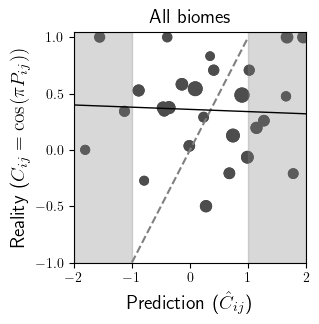

In [7]:
Pij=mismatch_matrix.values[:,:]                   # mismatch data 
K=len(Pij[0:])
Cos_data=np.zeros([K,K])
for i in range(K):
    for j in range(K):
        Cos_data[i,j]=np.cos(Pij[i,j]*np.pi)      # collinearity of functions based on mismatches

# vectors to fill in 
Norm=np.zeros([K,K]) 
Cos_hat=np.zeros([K,K])  

# theoretical prediction for the collinearity of functions based on their collinearity/mismatches with all others
for i in range(K):
    for j in range(K):
        Cij=np.delete(np.delete(Cos_data,[i,j],0),[i,j],1)
        R=inv(Cij)
        Norm[i,j]=norm(R)
        u=np.delete(Cos_data[i,:],[i,j])
        v=np.delete(Cos_data[j,:],[i,j])
        Cos_hat[i,j]=np.dot(np.dot(R,u),v)
        up=np.delete(Pij[i,:],[i,j])
        vp=np.delete(Pij[j,:],[i,j])
        
cos=np.ravel(Cos_data)    # ground truth
cos_hat=np.ravel(Cos_hat) # prediction
normM=np.ravel(Norm)      # sensitivity

roof=15 # upper bound on sensitivity - if the norm is too high this process won't work

# Plot the prediction against the empirical results (scale points by Norm - larger points with lower norms, more accurate)
plt.figure(num=None, figsize=(3, 3), dpi=100, facecolor='w', edgecolor='k')

plt.scatter(cos_hat[normM<roof],cos[normM<roof],s=500/normM[normM<roof], color = (0.3, 0.3, 0.3))
plt.title('All biomes', fontsize=14)
plt.plot([-1,1],[-1,1],'--', color = (0.5, 0.5, 0.5))
plt.fill_between([1,2],[-1,-1],[1.05,1.05],color=(0.5, 0.5, 0.5),alpha=0.3)
plt.fill_between([-2,-1],[-1,-1],[1.05,1.05],color=(0.5, 0.5, 0.5),alpha=0.3)

plt.xlabel('Prediction ($\hat{C}_{ij}$)',fontsize=14)
plt.ylabel('Reality ($C_{ij}=\cos(\pi P_{ij}))$',fontsize=14)
plt.ylim(-1,1.05)
plt.xlim(-2,2)

# linear fit
x=np.concatenate([cos_hat[normM<roof],cos_hat[normM<roof]])
y=np.concatenate([cos[normM<roof],cos[normM<roof]])
lin=np.polyfit(x,y,1)
z=np.linspace(-2,2,100)
plt.plot(z,z*lin[0]+lin[1],'k-',lw=1);

The second test we can do is ask if the mismatches between two functions can be estimated based on estimates of their broadness derived from their mismatches with total biomass.

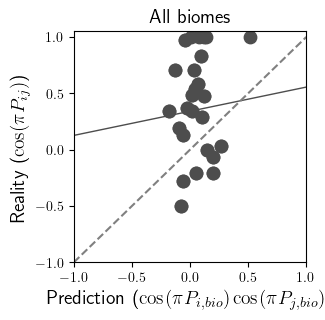

In [8]:
# Predicted collinearity based on estimated broadness (which is based on mismatches with biomass)
Prod=np.zeros([K-1,K-1])
for i in range(K-1):
    for j in range(K-1):
        Prod[i,j]=Cos_data[i,-1]*Cos_data[-1,j]      ### -1 refers to the last row and column which is biomass 

#delete these points as they will by definition fall on the 1:1 line
Cos_bio=np.delete(np.delete(Cos_data,K-1,0),K-1,1) 

# norm (again, too high and this won't make sense)
normM_red=np.delete(np.delete(Norm,K-1,0),K-1,1)
roof=15 # upper bound on sensitivity


# Plot the prediction against the empirical results
plt.figure(num=None, figsize=(3, 3), dpi=100, facecolor='w', edgecolor='k')

#linear fit
x=np.ravel(Prod[normM_red<roof])
y=np.ravel(Cos_bio[normM_red<roof])
p_all=np.polyfit(x,y,1)
z=np.linspace(-1,1,100)
plt.plot(z,z*p_all[0]+p_all[1],'-',lw=1, color = (0.3, 0.3, 0.3))

plt.scatter(Prod[normM_red<roof],Cos_bio[normM_red<roof],s=80, color = (0.3, 0.3, 0.3))
plt.title('All biomes', fontsize=14)

plt.xlabel('Prediction ($\cos(\pi P_{i,bio})\cos(\pi P_{j,bio}))$',fontsize=14)
plt.ylabel('Reality ($\cos(\pi P_{ij})$)',fontsize=14)
plt.plot([-1,1],[-1,1],'--', color = (0.5, 0.5, 0.5))
plt.ylim(-1,1.05)
plt.xlim(-1,1);

The results of theses tests wouldn't give you much confidence! But it is important to recognise that we are dealing with incredibly diverse data. Just look at the biomes that the experiments have been conducted in: 

In [9]:
cross_tab_result = pd.crosstab(zhou_data['Biomes'], 'count')
cross_tab_result.columns.name = None 
cross_tab_result.index.name = None  

cross_tab_result

,count
Agriculture,279
Desert,51
Grassland,367
Mediterranean,35
Tem/Bor Forest,209
Tro/Sub Forest,226
Tundra,32
Wetland,36


The tests above are assuming that the functions have the same directions in state space and are consistently impacted by perturbations in agricutlural systems, in tropical rainforests, in the tundra, and in wetlands.. It's not surprising at all that the tests above weren't convincing. 

Let's take grassland (n = 367) and forests (combination of Tem/Bor Forest and Tro/Sub Forest, n = 435) and run the tests with these subsets. Even though these data will still be from very different forests or grasslands around the world, we might expect that functions will be more consistent within these biomes.  

## Subset by biome  

In [10]:
grass = zhou_data[zhou_data['Biomes'] == 'Grassland']
forest = zhou_data[zhou_data['Biomes'].isin(['Tem/Bor Forest', 'Tro/Sub Forest'])]

As we have less data, we'll change min observation in the mismatch function to 5. This will introduce noise, but noisy data is better than no data!

At the min_obs value of 5, we need to remove PER from grass function list and we need to remove AG and XYL from the forest function list to ensure there are no NAs. 

In [11]:
# calculate matrix of mismatches for grassland subset
grass_list = ["PO", "AG", "BG", "CEL", "XYL", "NAG", "AP", "Respiration", "MicrobialBiomass"]
grass_matrix = pd.DataFrame(index=grass_list, columns=grass_list)
for X in grass_list:
    for Y in grass_list:
        grass_matrix.loc[X, Y] = mismatches(grass, X, Y, 5)   

# calculate matrix of mismatches for forest subset
forest_list = ["PO", "PER", "BG", "CEL", "NAG", "AP", "Respiration", "MicrobialBiomass"]
forest_matrix = pd.DataFrame(index=forest_list, columns=forest_list)
for X in forest_list:
    for Y in forest_list:
        forest_matrix.loc[X, Y] = mismatches(forest, X, Y, 5)   

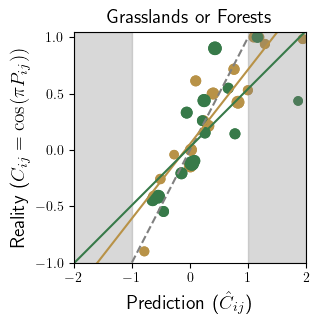

In [12]:
#########################################################
################### Grasslands ##########################
#########################################################

Pij=grass_matrix.values[:,:]                   # mismatch data 
K=len(Pij[0:])
Cos_data=np.zeros([K,K])
for i in range(K):
    for j in range(K):
        Cos_data[i,j]=np.cos(Pij[i,j]*np.pi)      # collinearity of functions based on mismatches
grass_Cos_data = Cos_data                         # save for the next plot
grass_K = K                                       # save for the next plot

        
# vectors to fill in 
Norm=np.zeros([K,K]) 
Cos_hat=np.zeros([K,K])  

# theoretical prediction for the collinearity of functions based on their collinearity/mismatches with all others
for i in range(K):
    for j in range(K):
        Cij=np.delete(np.delete(Cos_data,[i,j],0),[i,j],1)
        R=inv(Cij)
        Norm[i,j]=norm(R)
        u=np.delete(Cos_data[i,:],[i,j])
        v=np.delete(Cos_data[j,:],[i,j])
        Cos_hat[i,j]=np.dot(np.dot(R,u),v)
        up=np.delete(Pij[i,:],[i,j])
        vp=np.delete(Pij[j,:],[i,j])
grass_Norm = Norm                # to save for next plot 
     
grass_cos=np.ravel(Cos_data)    # ground truth
grass_cos_hat=np.ravel(Cos_hat) # prediction
grass_normM=np.ravel(Norm)      # sensitivity

#########################################################
##################### Forests ###########################
#########################################################

Pij=forest_matrix.values[:,:]                   # mismatch data 
K=len(Pij[0:])
Cos_data=np.zeros([K,K])
for i in range(K):
    for j in range(K):
        Cos_data[i,j]=np.cos(Pij[i,j]*np.pi)      # collinearity of functions based on mismatches
forest_Cos_data = Cos_data                         # save for the next plot
forest_K = K                                       # save for the next plot


# vectors to fill in 
Norm=np.zeros([K,K]) 
Cos_hat=np.zeros([K,K])  

# theoretical prediction for the collinearity of functions based on their collinearity/mismatches with all others
for i in range(K):
    for j in range(K):
        Cij=np.delete(np.delete(Cos_data,[i,j],0),[i,j],1)
        R=inv(Cij)
        Norm[i,j]=norm(R)
        u=np.delete(Cos_data[i,:],[i,j])
        v=np.delete(Cos_data[j,:],[i,j])
        Cos_hat[i,j]=np.dot(np.dot(R,u),v)
        up=np.delete(Pij[i,:],[i,j])
        vp=np.delete(Pij[j,:],[i,j])
forest_Norm = Norm                # to save for next plot 

forest_cos=np.ravel(Cos_data)    # ground truth
forest_cos_hat=np.ravel(Cos_hat) # prediction
forest_normM=np.ravel(Norm)      # sensitivity

#########################################################
##################### Plotting ##########################
#########################################################

plt.figure(num=None, figsize=(3, 3), dpi=100, facecolor='w', edgecolor='k')

roof=15 # upper bound on sensitivity - if the norm is too high this process won't work

# Plot the prediction against the empirical results (scale points by Norm - larger points with lower norms, more accurate)
plt.scatter(grass_cos_hat[grass_normM<roof],grass_cos[grass_normM<roof],s=500/grass_normM[grass_normM<roof], color = grass_col)
plt.scatter(forest_cos_hat[forest_normM<roof],forest_cos[forest_normM<roof],s=500/forest_normM[forest_normM<roof], color = forest_col)
plt.title('Grasslands or Forests', fontsize=14)
plt.plot([-1,1],[-1,1],'--', color = (0.5, 0.5, 0.5))
plt.fill_between([1,2],[-1,-1],[1.05,1.05],color=(0.5, 0.5, 0.5),alpha=0.3)
plt.fill_between([-2,-1],[-1,-1],[1.05,1.05],color=(0.5, 0.5, 0.5),alpha=0.3)

plt.xlabel('Prediction ($\hat{C}_{ij}$)',fontsize=14)
plt.ylabel('Reality ($C_{ij}=\cos(\pi P_{ij}))$',fontsize=14)
plt.ylim(-1,1.05)
plt.xlim(-2,2)

# grass fit
x=np.concatenate([grass_cos_hat[grass_normM<roof],grass_cos_hat[grass_normM<roof]])
y=np.concatenate([grass_cos[grass_normM<roof],grass_cos[grass_normM<roof]])
lin=np.polyfit(x,y,1)
z=np.linspace(-2,2,100)
plt.plot(z,z*lin[0]+lin[1],'-',lw=1.5,color=grass_col);

# forest fit
x=np.concatenate([forest_cos_hat[forest_normM<roof],forest_cos_hat[forest_normM<roof]])
y=np.concatenate([forest_cos[forest_normM<roof],forest_cos[forest_normM<roof]])
lin=np.polyfit(x,y,1)
z=np.linspace(-2,2,100)
plt.plot(z,z*lin[0]+lin[1],'-',lw=1.5,color=forest_col);



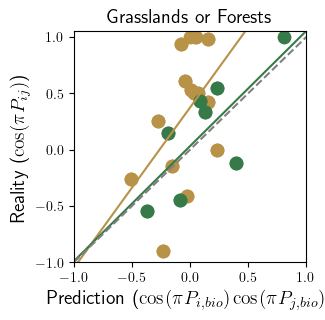

In [13]:
#########################################################
##################### Grasslands ########################
#########################################################

K = grass_K

# Predicted collinearity based on estimated broadness (which is based on mismatches with biomass)
grass_Prod=np.zeros([K-1,K-1])
for i in range(K-1):
    for j in range(K-1):
        grass_Prod[i,j]=grass_Cos_data[i,-1]*grass_Cos_data[-1,j]      ### -1 refers to the last row and column which is biomass 

#delete these points as they will by definition fall on the 1:1 line
grass_Cos_bio=np.delete(np.delete(grass_Cos_data,K-1,0),K-1,1) 

# norm (again, too high and this won't make sense)
grass_normM_red=np.delete(np.delete(grass_Norm,K-1,0),K-1,1)


#########################################################
##################### Forest ##########################
#########################################################

K = forest_K

# Predicted collinearity based on estimated broadness (which is based on mismatches with biomass)
forest_Prod=np.zeros([K-1,K-1])
for i in range(K-1):
    for j in range(K-1):
        forest_Prod[i,j]=forest_Cos_data[i,-1]*forest_Cos_data[-1,j]      ### -1 refers to the last row and column which is biomass 

#delete these points as they will by definition fall on the 1:1 line
forest_Cos_bio=np.delete(np.delete(forest_Cos_data,K-1,0),K-1,1) 

# norm (again, too high and this won't make sense)
forest_normM_red=np.delete(np.delete(forest_Norm,K-1,0),K-1,1)


#########################################################
##################### Plotting ##########################
#########################################################

plt.figure(num=None, figsize=(3, 3), dpi=100, facecolor='w', edgecolor='k')

plt.scatter(grass_Prod[grass_normM_red<roof],grass_Cos_bio[grass_normM_red<roof],s=80, color = grass_col)
plt.scatter(forest_Prod[forest_normM_red<roof],forest_Cos_bio[forest_normM_red<roof],s=80, color = forest_col)

plt.title('Grasslands or Forests', fontsize=14)

# grass fit
x=np.ravel(grass_Prod[grass_normM_red<roof])
y=np.ravel(grass_Cos_bio[grass_normM_red<roof])
p_grass=np.polyfit(x,y,1)
z=np.linspace(-1,1,100)
plt.plot(z,z*p_grass[0]+p_grass[1],'-',lw=1.5, color = grass_col)

# forest fit
x=np.ravel(forest_Prod[forest_normM_red<roof])
y=np.ravel(forest_Cos_bio[forest_normM_red<roof])
p_forest=np.polyfit(x,y,1)
z=np.linspace(-1,1,100)
plt.plot(z,z*p_forest[0]+p_forest[1],'-',lw=1.5, color = forest_col)

plt.xlabel('Prediction ($\cos(\pi P_{i,bio})\cos(\pi P_{j,bio}))$',fontsize=14)
plt.ylabel('Reality ($\cos(\pi P_{ij})$)',fontsize=14)
plt.plot([-1,1],[-1,1],'--', color = (0.5, 0.5, 0.5))
plt.ylim(-1,1.05)
plt.xlim(-1,1);

The results of these two tests are really reassuring! We can definitely use our geometric approach for these data. Functions can really be approximated well by directions in state space. Now we can use our theory to have a deeper look into the empirical data. 

<br>
<br>

## Empirical insights  <a class="anchor" id="4"></a>
[Top](#1)

### 1. Map of functions

One first thing we can do is to take the mismatch matrices for grasslands or forests and to use it as an adjacency matrix for a graph. We would expect that mechanistically similar functions will be near each other in the graphs. Go with grassland data as this has one more node than forests (both show very similar networks, which is very reassuring). 

We'll use the Kamada-Kawai path-length cost-function to determine the layout of the network (Tomihisa Kamada and Satoru Kawai. An Algorithm for Drawing General Undirected Graphs. Information Processing Letters 31:7-15, 1989). This is a force-directed algorithm that treats the network as a system of springs - distance in the network should correspond to the amount of mismatches (more mismatches leads to more repulsion between nodes). 

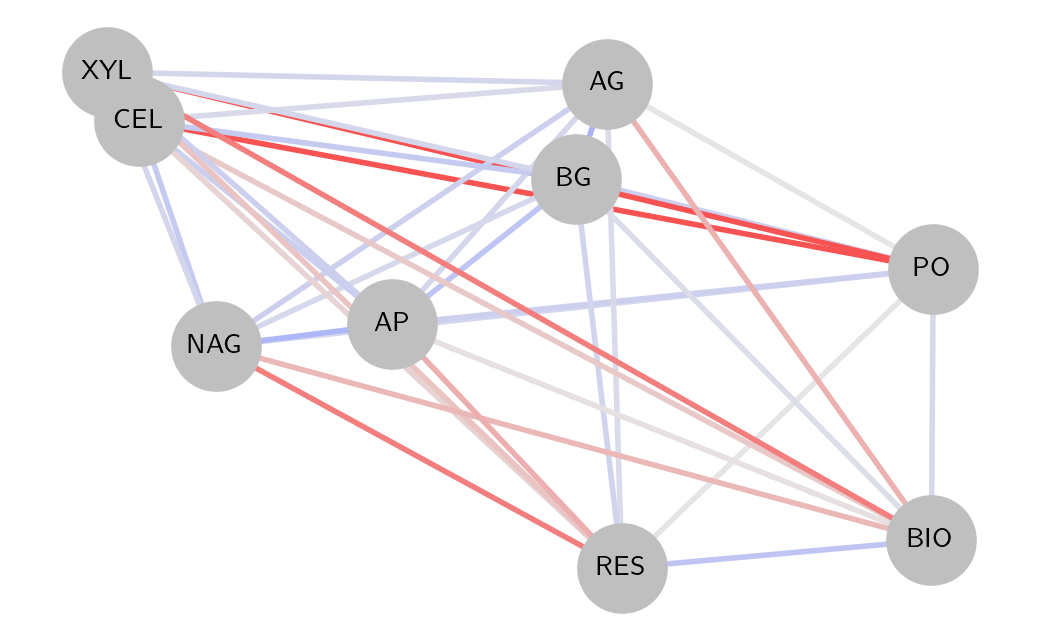

In [14]:
plt.figure(num=None, figsize=(5, 3), dpi=200, facecolor='w', edgecolor='k')

# convert pandas object to numpy array (making sure all entries are numeric)
grass_matrix = grass_matrix.apply(pd.to_numeric, errors='coerce')
adjacency_matrix = grass_matrix.values

# convert to a network object
G = nx.from_numpy_array(adjacency_matrix)

# set node names
node_names = dict(enumerate(grass_matrix.columns))
G = nx.relabel_nodes(G, node_names)

# shorten respiration and biomass 
old_node_names = list(G.nodes)
new_node_names = {'Respiration': 'RES', 'MicrobialBiomass': 'BIO'}
G = nx.relabel_nodes(G, new_node_names)

# set layout
pos = nx.kamada_kawai_layout(G)

# set edge weights
weights = nx.get_edge_attributes(G, 'weight')

# Map weights to colors in the colormap
blue = (0.6, 0.65, 1)
red = (1, 0.1, 0.1)
white = (0.9, 0.9, 0.9)
cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', [blue, white, red], N=256)
edge_colors = [cmap(weight) for weight in weights.values()]

# draw the network
nx.draw(G, pos, with_labels=True, 
        font_weight='bold', node_size=1000, 
        node_color=[[0.75, 0.75, 0.75]], 
        edge_color= edge_colors, #[[0.75, 0.75, 0.75]],
        font_size=10, 
        font_color='black',
        width=2)

# Create a colorbar
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
#sm.set_array([])
#plt.colorbar(sm, label='Mismatches', shrink = 0.4, aspect = 5);



As a reminder the functions in our dataset are: 

**Broad Functions**

1. microbial respiration
2. microbial biomass 
2. net N mineralization rate

**Relative Broad Functions related to nitrogen cycling**

3. nitrification activity
4. denitrification activity
5. biological N2 fixation

**Oxidative C-cycling enzymes**

6. phenol oxidase (PO)
7. peroxidase (PER)

**Hydrolytic C-cycling enzymes**

8. α-1,4-glucosidase (AG)
9. β-1,4-glucosidase (BG)
10. cellobiohydrolase(CEL)
11. β-1,4-xylosidase (XYL)
12. invertase

**N-cycling enzymes**

13. N-acetyl-β-glucosaminidase (NAG)
14. L-leucine aminopeptidase (LAP)
15. urease

**P-cycling enzymes**

16. phosphatase (AP)

### 2. Quantify broadness of functions

We know that total biomass is the “broadest” ecosystem function; it’s vector of species per-capita contributions is, by definition, made up entirely of ones. We can therefore use total biomass as a baseline to quantify the broadness of other functions. The angle between biomass and other broad functions will be small so, over many perturbations with random effects, the proportion of mismatches will therefore be low. Narrower functions will have larger angles with biomass, which will result in higher proportions of mismatches. 

Working in reverse, we can use the proportion of mismatches between some function and total biomass (directly available from the data) to predict the broadness of that function. For a fair estimate of broadness, the proportion of mismatches between the function and biomass should be quantified over a large pool of perturbations that collectively have random effects. Here, we do not consider perturbations of nutrients for ecosystem functions related to that nutrient – these perturbations have systematic effects rather than random effects – and we only consider cases where the proportion of mismatches between a function and biomass is based on at least twenty perturbations including at least five types of global change factors. 

In [15]:
# function to estimate broadness of a function
def broadness_func(data, func, biome):
    
    # subset just the pair of functions
    sub = data[["MicrobialBiomass", func, "GC"]].dropna()

    # option to exclude perturbations that are directly related to an ecosystem function (that have systematic effects)
    excluded = []
    if func in ["Nmin", "Nitrification", "Denitrification", "Nfixation", "Urease", "NAG", "LAP"]:
        excluded = ["N", "N_P"]
    elif func == "AP":
        excluded = ["P", "N_P"]
    sub = sub[~sub["GC"].isin(excluded)]
    
    # calculate mismatches
    mismatch = mismatches(sub, "MicrobialBiomass", func, 10)
    
    # count number of perturbations
    NP = len(sub)
    
    # count number of perturbation types 
    NPtype = len(sub["GC"].unique())
    
    new_values = pd.DataFrame({
        "func": [func],
        "NP": [NP],
        "NPtype": [NPtype],
        "biome": [biome],
        "mismatch": [mismatch]
    })
    
    return new_values


# List of functions (except MicrobialBiomass)
full_list = [
    "PO", "PER", "AG", "BG", "CEL", "XYL", "Invertase",
    "NAG", "LAP", "Urease", "AP",
    "Respiration", "Nmin",
    "Nitrification", "Denitrification", "Nfixation"
]


# empty dataframe to fill in 
broadness = pd.DataFrame()

# loop over forests and grasslands and across all functions to calculate broadness
for biome, data in [("grasslands", grass), ("forests", forest)]:
    for func in full_list:        
        new_values = broadness_func(data, func, biome)
        broadness = pd.concat([broadness, new_values], ignore_index=True)

# only take measures of broadness that are based on many perturbations of a range of types
broadness_data = broadness.dropna().loc[broadness["NP"] >= 20].loc[broadness["NPtype"] >= 5]
broadness_data["broadness"] = np.cos(np.pi * broadness_data["mismatch"].astype(float))**2
broadness_data["NP"] = broadness_data["NP"].astype(float)

forest_broad = broadness_data[broadness_data['biome'] == 'forests']
grass_broad = broadness_data[broadness_data['biome'] == 'grasslands']

# sort the order from highest to lowest broadness 
order = ["Respiration", "Nmin", "PO", "BG", "AP"]
grass_broad = grass_broad.copy()
grass_broad['func'] = pd.Categorical(grass_broad['func'], categories=order, ordered=True)
grass_broad = grass_broad.sort_values(by='func')
grass_broad = grass_broad.reset_index(drop=True)

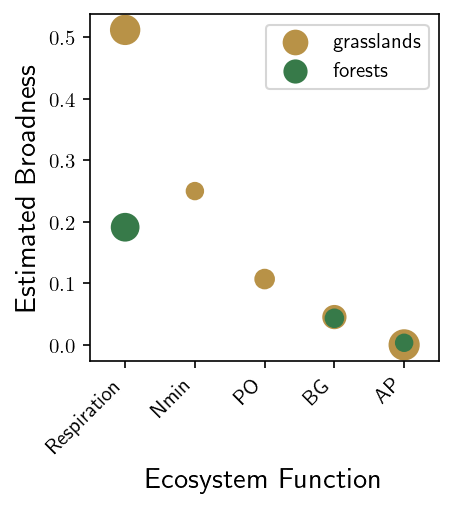

In [16]:
plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')

plt.scatter(grass_broad['func'], grass_broad['broadness'],
        s = grass_broad['NP']**1.25, c = grass_col, label = "grasslands")
plt.scatter(forest_broad['func'], forest_broad['broadness'],
        s = forest_broad['NP']**1.25, c = forest_col, label = "forests")
plt.title('')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Ecosystem Function', labelpad=5, fontsize = 14)
plt.ylabel('Estimated Broadness', fontsize = 14)
plt.legend()
plt.xlim(-0.5, 4.5)
plt.show()

plt.show()

### 3. Quantify response diversity

Now we turn our attention to the perturbations in the dataset and we try to estimate their response diversity by comparing the mismatches between two broad functions (Biomass and Respiration) for each perturbation. Relatively lower proportion of mismatches indicates relatively lower response diversity. 

The perturbations are: Warming (W), carbon dioxide enrichment (eCO2), decreased precipitation (PPT-), increased precipitation (PPT+), phosphorous addition (P), nitrogen addition (N), land use change (LUC), W×eCO2, N×PPT+, N plus P plus potassium addition (N×P×K)). Land use change can be subdivided into: landuse change types (NEtoAgr, conversion from native ecosystem to agriculture; NEtoPas, conversion from native ecosystem to pasture; NEtoPlant, conversion from native ecosystem to plantation; NEtoSec, conversion from native ecosystem to secondary ecosystem)

In [17]:
# general organising
forest_RD = (forest[['MicrobialBiomass', 'Respiration', 'GC', 'LUC']]
              .dropna(subset=['MicrobialBiomass', 'Respiration'])
              .assign(mismatch=lambda x: np.where(np.sign(x['MicrobialBiomass']) == np.sign(x['Respiration']), 0, 1)))

# LUC can be subdivided
forest_RD['GC'] = np.where(forest_RD['GC'] == 'LUC', forest_RD['LUC'], forest_RD['GC'])

# Must have at least 5 observations
forest_RD = (forest_RD.groupby('GC')
              .filter(lambda x: len(x) >= 5)
              .reset_index(drop=True))

# get proportion of mismatches
counts = forest_RD['GC'].value_counts().reset_index()
prop_counts = pd.crosstab(forest_RD['GC'], forest_RD['mismatch'])
proportions = prop_counts.div(prop_counts.sum(axis=1), axis=0).reset_index()

# some messing around to get into a nice format
forest_RD = (proportions.reset_index()
              .merge(counts, how="left", on = "GC")
              .assign(biome='forests')
              .drop(['index'], axis=1))
forest_RD = forest_RD.rename(columns={forest_RD.columns[1]: 'Agree'})
forest_RD = forest_RD.rename(columns={forest_RD.columns[2]: 'Mismatches'})
forest_RD = forest_RD.rename(columns={forest_RD.columns[3]: 'N'})

#### repeat the above for grasslands 
grass_RD = (grass[['MicrobialBiomass', 'Respiration', 'GC', 'LUC']]
              .dropna(subset=['MicrobialBiomass', 'Respiration'])
              .assign(mismatch=lambda x: np.where(np.sign(x['MicrobialBiomass']) == np.sign(x['Respiration']), 0, 1)))

grass_RD['GC'] = np.where(grass_RD['GC'] == 'LUC', grass_RD['LUC'], grass_RD['GC'])

grass_RD = (grass_RD.groupby('GC')
              .filter(lambda x: len(x) >= 5)
              .reset_index(drop=True))

counts = grass_RD['GC'].value_counts().reset_index()
prop_counts = pd.crosstab(grass_RD['GC'], grass_RD['mismatch'])
proportions = prop_counts.div(prop_counts.sum(axis=1), axis=0).reset_index()

grass_RD = (proportions.reset_index()
              .merge(counts, how="left", on = "GC")
              .assign(biome='grasslands')
              .drop(['index'], axis=1))
grass_RD = grass_RD.rename(columns={grass_RD.columns[1]: 'Agree'})
grass_RD = grass_RD.rename(columns={grass_RD.columns[2]: 'Mismatches'})
grass_RD = grass_RD.rename(columns={grass_RD.columns[3]: 'N'})

# to avoid annoying Latex bugs 
grass_RD['GC'] = grass_RD['GC'].replace('N_P', 'N and P')
forest_RD['GC'] = forest_RD['GC'].replace('N_P', 'N and P')

RD_data = pd.concat([grass_RD, forest_RD])

# set order from low to high response diversity 
# sort the order from highest to lowest broadness 
order = ["NEtoSec", "eCO2", "NEtoPas", "NEtoAgr", "N and P", "NEtoPlant", "N", "W"]
RD_data = RD_data.copy()
RD_data['GC'] = pd.Categorical(RD_data['GC'], categories=order, ordered=True)
RD_data = RD_data.sort_values(by='GC')
RD_data = RD_data.reset_index(drop=True)

# for colour 
RD_data['colour'] = np.where(RD_data['biome'] == 'grasslands', grass_col, forest_col)


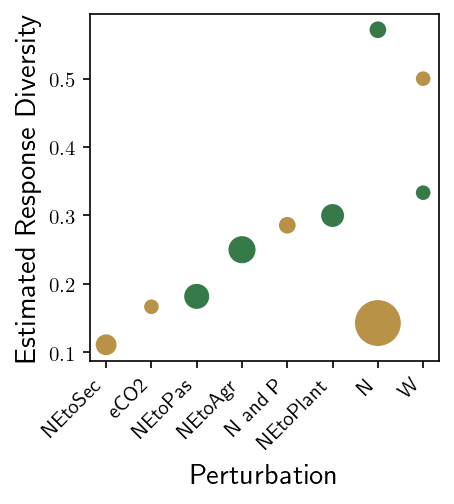

In [18]:
plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')

plt.scatter(RD_data['GC'], RD_data['Mismatches'],
        s = RD_data['N']**2, c = RD_data['colour'])
plt.title('', fontsize = 14)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Perturbation', labelpad=5, fontsize = 14)
plt.ylabel('Estimated Response Diversity', fontsize = 14)
plt.show()

### 4. Quantify biomass scaling

By comparing the mimsmatches between biomass and a diversity metric (e.g., Shannon) for each perturbation we can estimate their biomass scaling. Relatlively higher proportions of mismatches means relatively higher scaling by biomass. 

In [25]:
# general organising
forest_BS = (forest[['MicrobialBiomass', 'Shannon', 'GC', 'LUC']]
              .dropna(subset=['MicrobialBiomass', 'Shannon'])
              .assign(mismatch=lambda x: np.where(np.sign(x['MicrobialBiomass']) == np.sign(x['Shannon']), 0, 1)))

# LUC can be subdivided
forest_BS['GC'] = np.where(forest_BS['GC'] == 'LUC', forest_BS['LUC'], forest_BS['GC'])

# Must have at least 5 observations
forest_BS = (forest_BS.groupby('GC')
              .filter(lambda x: len(x) >= 5)
              .reset_index(drop=True))

# get proportion of mismatches
counts = forest_BS['GC'].value_counts().reset_index()
prop_counts = pd.crosstab(forest_BS['GC'], forest_BS['mismatch'])
proportions = prop_counts.div(prop_counts.sum(axis=1), axis=0).reset_index()

# some messing around to get into a nice format
forest_BS = (proportions.reset_index()
              .merge(counts, how="left", on = "GC")
              .assign(biome='forests')
              .drop(['index'], axis=1))
forest_BS = forest_BS.rename(columns={forest_BS.columns[1]: 'Agree'})
forest_BS = forest_BS.rename(columns={forest_BS.columns[2]: 'Mismatches'})
forest_BS = forest_BS.rename(columns={forest_BS.columns[3]: 'N'})

#### repeat the above for grasslands 
grass_BS = (grass[['MicrobialBiomass', 'Shannon', 'GC', 'LUC']]
              .dropna(subset=['MicrobialBiomass', 'Shannon'])
              .assign(mismatch=lambda x: np.where(np.sign(x['MicrobialBiomass']) == np.sign(x['Shannon']), 0, 1)))

grass_BS['GC'] = np.where(grass_BS['GC'] == 'LUC', grass_BS['LUC'], grass_BS['GC'])

grass_BS = (grass_BS.groupby('GC')
              .filter(lambda x: len(x) >= 5)
              .reset_index(drop=True))

counts = grass_BS['GC'].value_counts().reset_index()
prop_counts = pd.crosstab(grass_BS['GC'], grass_BS['mismatch'])
proportions = prop_counts.div(prop_counts.sum(axis=1), axis=0).reset_index()

grass_BS = (proportions.reset_index()
              .merge(counts, how="left", on = "GC")
              .assign(biome='grasslands')
              .drop(['index'], axis=1))
grass_BS = grass_BS.rename(columns={grass_BS.columns[1]: 'Agree'})
grass_BS = grass_BS.rename(columns={grass_BS.columns[2]: 'Mismatches'})
grass_BS = grass_BS.rename(columns={grass_BS.columns[3]: 'N'})

# to avoid annoying Latex bugs 
grass_BS['GC'] = grass_BS['GC'].replace('N_PPT+', 'N and PPT')
forest_BS['GC'] = forest_BS['GC'].replace('N_PPT+', 'N and PPT')

BS_data = pd.concat([grass_BS, forest_BS])

# set order from low to high response diversity 
# sort the order from highest to lowest broadness 
order = ["P", "W", "N and PPT", "NEtoPlant", "N", "NEtoPas", "NEtoAgr", "NEtoSec"]
BS_data = BS_data.copy()
BS_data['GC'] = pd.Categorical(BS_data['GC'], categories=order, ordered=True)
BS_data = BS_data.sort_values(by='GC')
BS_data = BS_data.reset_index(drop=True)

# for colour 
BS_data['colour'] = np.where(BS_data['biome'] == 'grasslands', grass_col, forest_col)


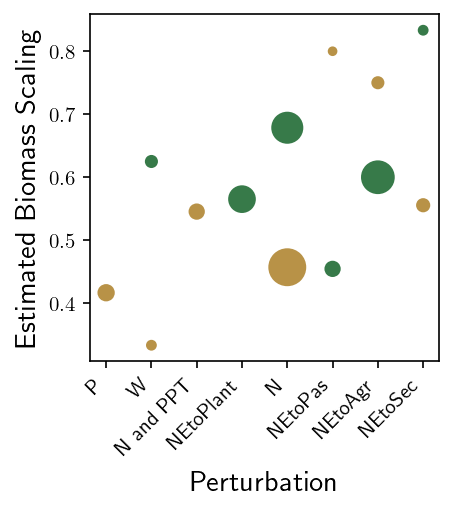

In [26]:
plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')

plt.scatter(BS_data['GC'], BS_data['Mismatches'],
        s = BS_data['N']**1.6, c = BS_data['colour'])
plt.title('', fontsize = 14)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Perturbation', labelpad=5, fontsize = 14)
plt.ylabel('Estimated Biomass Scaling', fontsize = 14)
plt.show()

### 4. Quantify biomass scaling using OTU richness as diversity metric


In [42]:
# general organising
forest_BS = (forest[['MicrobialBiomass', 'OTU', 'GC', 'LUC']]
              .dropna(subset=['MicrobialBiomass', 'OTU'])
              .assign(mismatch=lambda x: np.where(np.sign(x['MicrobialBiomass']) == np.sign(x['OTU']), 0, 1)))

# LUC can be subdivided
forest_BS['GC'] = np.where(forest_BS['GC'] == 'LUC', forest_BS['LUC'], forest_BS['GC'])

# Must have at least 5 observations
forest_BS = (forest_BS.groupby('GC')
              .filter(lambda x: len(x) >= 5)
              .reset_index(drop=True))

# get proportion of mismatches
counts = forest_BS['GC'].value_counts().reset_index()
prop_counts = pd.crosstab(forest_BS['GC'], forest_BS['mismatch'])
proportions = prop_counts.div(prop_counts.sum(axis=1), axis=0).reset_index()

# some messing around to get into a nice format
forest_BS = (proportions.reset_index()
              .merge(counts, how="left", on = "GC")
              .assign(biome='forests')
              .drop(['index'], axis=1))
forest_BS = forest_BS.rename(columns={forest_BS.columns[1]: 'Agree'})
forest_BS = forest_BS.rename(columns={forest_BS.columns[2]: 'Mismatches'})
forest_BS = forest_BS.rename(columns={forest_BS.columns[3]: 'N'})

#### repeat the above for grasslands 
grass_BS = (grass[['MicrobialBiomass', 'OTU', 'GC', 'LUC']]
              .dropna(subset=['MicrobialBiomass', 'OTU'])
              .assign(mismatch=lambda x: np.where(np.sign(x['MicrobialBiomass']) == np.sign(x['OTU']), 0, 1)))

grass_BS['GC'] = np.where(grass_BS['GC'] == 'LUC', grass_BS['LUC'], grass_BS['GC'])

grass_BS = (grass_BS.groupby('GC')
              .filter(lambda x: len(x) >= 5)
              .reset_index(drop=True))

counts = grass_BS['GC'].value_counts().reset_index()
prop_counts = pd.crosstab(grass_BS['GC'], grass_BS['mismatch'])
proportions = prop_counts.div(prop_counts.sum(axis=1), axis=0).reset_index()

grass_BS = (proportions.reset_index()
              .merge(counts, how="left", on = "GC")
              .assign(biome='grasslands')
              .drop(['index'], axis=1))
grass_BS = grass_BS.rename(columns={grass_BS.columns[1]: 'Agree'})
grass_BS = grass_BS.rename(columns={grass_BS.columns[2]: 'Mismatches'})
grass_BS = grass_BS.rename(columns={grass_BS.columns[3]: 'N'})

# to avoid annoying Latex bugs 
grass_BS['GC'] = grass_BS['GC'].replace('N_PPT+', 'N and PPT')
forest_BS['GC'] = forest_BS['GC'].replace('N_PPT+', 'N and PPT')

BS_data = pd.concat([grass_BS, forest_BS])

# set order from low to high response diversity 
# sort the order from highest to lowest broadness 
order = ["PPT+", "N", "W", "PPT-", "eCO2", "N and PPT",  "NEtoPlant", "NEtoAgr", "P", "N_P",  "NEtoSec", "NEtoPas"]
BS_data = BS_data.copy()
BS_data['GC'] = pd.Categorical(BS_data['GC'], categories=order, ordered=True)
BS_data = BS_data.sort_values(by='GC')
BS_data = BS_data.reset_index(drop=True)

# for colour 
BS_data['colour'] = np.where(BS_data['biome'] == 'grasslands', grass_col, forest_col)


In [43]:
BS_data

,GC,Agree,Mismatches,N,biome,colour
0,PPT+,0.714286,0.285714,7,grasslands,#b89247
1,N,0.629630,0.370370,27,grasslands,#b89247
2,N,0.548387,0.451613,31,forests,#377A49
3,W,0.727273,0.272727,11,grasslands,#b89247
4,W,0.333333,0.666667,9,forests,#377A49
5,PPT-,0.500000,0.500000,6,forests,#377A49
6,eCO2,0.428571,0.571429,7,grasslands,#b89247
7,N and PPT,0.400000,0.600000,10,grasslands,#b89247
8,NEtoPlant,0.388889,0.611111,18,forests,#377A49
9,NEtoAgr,0.428571,0.571429,7,grasslands,#b89247


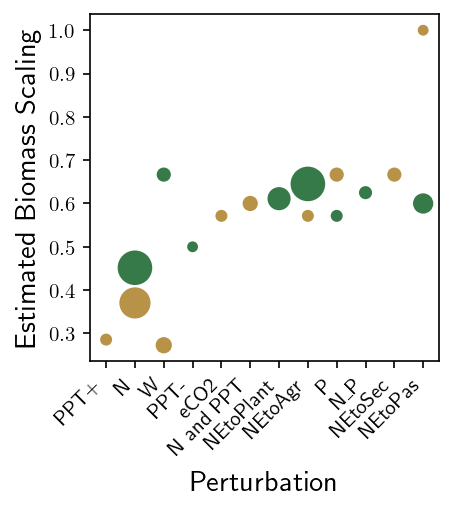

In [44]:
plt.figure(num=None, figsize=(3, 3), dpi=150, facecolor='w', edgecolor='k')

plt.scatter(BS_data['GC'], BS_data['Mismatches'],
        s = BS_data['N']**1.6, c = BS_data['colour'])
plt.title('', fontsize = 14)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Perturbation', labelpad=5, fontsize = 14)
plt.ylabel('Estimated Biomass Scaling', fontsize = 14)
plt.show()